# Uncertainty Quantification for Polar Lows

In [ ]:
import numpy as np
import torch 
import os
from dataloaders import get_transforms, create_dataloaders
from model_builder import XceptionCustom, XceptionCustomBLITZ
from utils import evaluate_model
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
import matplotlib.pyplot as plt
from blitz.utils import variational_estimator
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from blitz.modules import BayesianConv2d, BayesianLinear


In [ ]:
# select device
if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

# create directories
train_dir = os.path.join('data', 'train')
test_dir = os.path.join('data', 'test')

train_sub_dir = os.path.join('data_sub/train')
test_sub_dir = os.path.join('data_sub/test')

mps


## Original Model 

In [3]:
# load data and inspect trained model performance (architecture as in paper - trained on local machine for fewer epochs) 
# to inspect architecture: see XceptionCustom in model_builder script

train_transform, test_transform = get_transforms()
train_loader, test_loader, n_pos_train, n_neg_train, class_to_idx_dict = create_dataloaders(train_dir, test_dir, train_transform, test_transform)

print(class_to_idx_dict)

# Load the best model weights
model = XceptionCustom(input_channels=3)
model.load_state_dict(torch.load('models/trained_model.pth'))

Positive training samples: 254 (16%), Negative training samples: 1293 (83%)
{'neg': 0, 'pos': 1}


<All keys matched successfully>

In [4]:
# evaluate model 
y_pred_labels_np, y_true_np, y_pred_probs_np, misclassified_images, misclassified_true_labels, misclassified_pred_labels, misclassified_prob_vectors = evaluate_model(model, test_loader, device)

# Print classification report
print("\nClassification Report on Test Set:")
print(classification_report(y_true_np, y_pred_labels_np))
print(f"\nFound {len(misclassified_images)} misclassified images.")



Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       371
           1       0.91      0.97      0.94        64

    accuracy                           0.98       435
   macro avg       0.95      0.98      0.96       435
weighted avg       0.98      0.98      0.98       435


Found 8 misclassified images.


In [5]:
train_sub_loader, test_sub_loader, n_pos_sub_train, n_neg_sub_train, _ = create_dataloaders(train_sub_dir, test_sub_dir, train_transform, test_transform)

Positive training samples: 10 (50%), Negative training samples: 10 (50%)


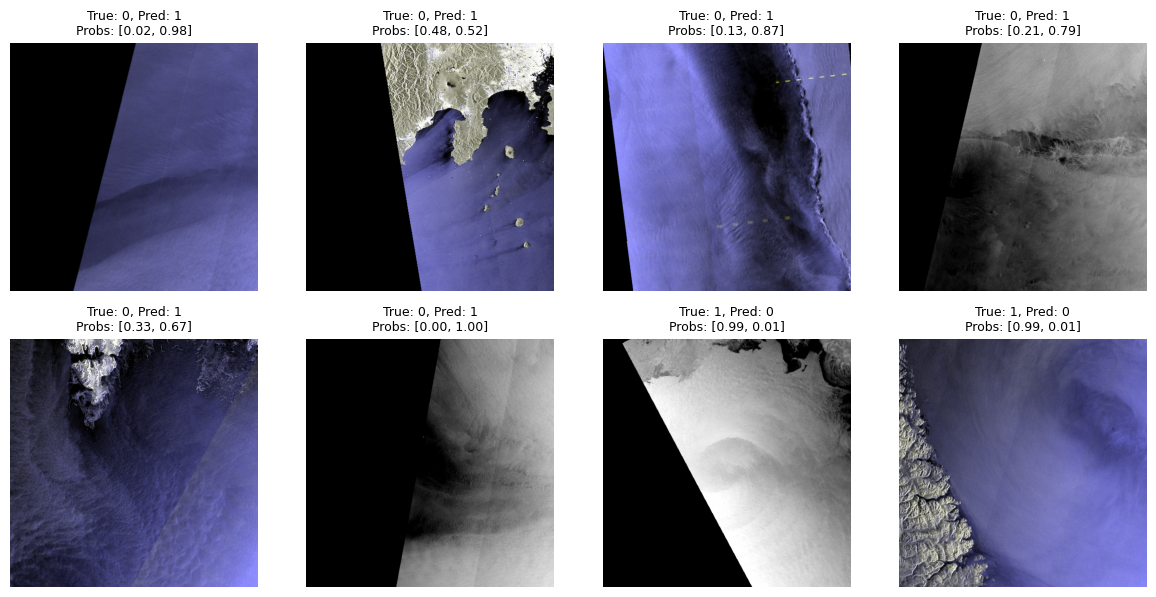

In [6]:
# --- plot misclassified images with probabilities ---
fig, axes = plt.subplots(4, 4, figsize=(12, 12)) # Create a 4x4 grid of subplots
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

for i in range(len(misclassified_images)):
    ax = axes[i]
    # Convert the image tensor (CHW) to NumPy array (HWC) for matplotlib
    img = misclassified_images[i].permute(1, 2, 0).numpy()
    ax.imshow(img)

    # Format the probability vector for display
    prob_vec = misclassified_prob_vectors[i].numpy()
    # Assuming two classes, e.g., [prob_neg, prob_pos]
    subtitle = f"True: {misclassified_true_labels[i]}, Pred: {misclassified_pred_labels[i]}\nProbs: [{prob_vec[0]:.2f}, {prob_vec[1]:.2f}]"
    ax.set_title(subtitle, fontsize=9) # Adjust fontsize as needed
    ax.axis('off') # Turn off the axes for each subplot

# Hide any unused subplots if fewer than 16 images are displayed
for j in range(len(misclassified_images), 16):
    fig.delaxes(axes[j])

plt.tight_layout() 
plt.show()

## BLITZ experiments

In [7]:
# --- Training Function ---
def train_model(model, train_loader, optimizer, criterion, device, num_epochs, vi_samples):
    for epoch in range(num_epochs):
        model.train() # Set model to training mode
        running_loss = 0.0
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        
        for i, (images, labels) in enumerate(pbar):
            images, labels = images.to(device), labels.to(device)
            
            # --- ELBO Training Step ---
            optimizer.zero_grad()
            
            # Compute the variational free energy loss (ELBO)
            loss = model.sample_elbo(inputs=images,
                                     labels=labels,
                                     criterion=criterion,
                                     sample_nbr=vi_samples,
                                     complexity_cost_weight=1/len(train_loader.dataset))
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # Update progress bar description with the current average loss
            pbar.set_postfix({'loss': f'{running_loss/(i+1):.4f}'})

        avg_train_loss = running_loss / len(train_loader)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Average Training ELBO Loss: {avg_train_loss:.4f}")




NUM_EPOCHS = 2

# Number of MC samples for ELBO calculation
VI_SAMPLES = 3

# --- Data Loader ---
train_loader = train_sub_loader

# --- Model, Optimizer, and Loss ---
model = XceptionCustomBLITZ(input_channels=3).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# --- Run Training ---
train_model(model=model,
            train_loader=train_loader,
            optimizer=optimizer,
            criterion=criterion,
            device=device,
            num_epochs=NUM_EPOCHS,
            vi_samples=VI_SAMPLES)



Epoch 1/2: 100%|██████████| 3/3 [00:17<00:00,  5.94s/it, loss=194011.9792]


Epoch [1/2], Average Training ELBO Loss: 194011.9792


Epoch 2/2: 100%|██████████| 3/3 [00:16<00:00,  5.66s/it, loss=192708.2135]

Epoch [2/2], Average Training ELBO Loss: 192708.2135
